# Download packages

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (211 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf

In [ ]:
# Define Global variables
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_SIZE = 1000
BATCH_SIZE = 32

# Download zip files from drive and extract

In [ ]:
from google.colab import drive

# Mount drive
drive.mount("/content/gdrive", force_remount=True)
# drive.mount('/gdrive')
drive_root = '/content/gdrive/My Drive/COMS4995/slides2/'

Mounted at /content/gdrive


## Verify slide contents

In [ ]:
slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_path = drive_root + slide_path # only this file is available
tumor_mask_path = drive_root + tumor_mask_path # only this file is available

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)-1):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/gdrive/My Drive/COMS4995/slides2/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/gdrive/My Drive/COMS4995/slides2/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64


# Helper functions - read slide and check tissue

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1])), im_gray

In [ ]:
def save_slide(slide_image, path, save_name, i, j):
  im = Image.fromarray(slide_image)
  name = save_name + str(i) + "-" + str(j) + ".png"
  name_slide =  os.path.join(path, name)
  im.save(name_slide)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

# Reading image examples

## Display Tumor 091 at Level 4

In [ ]:
slide_path = drive_root + 'tumor_091.tif' # only this file is available
tumor_mask_path = drive_root + 'tumor_091_mask.tif' # only this file is available

slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

(3360, 3840, 3)
3451212 tissue_pixels pixels (26.7 percent of the image)


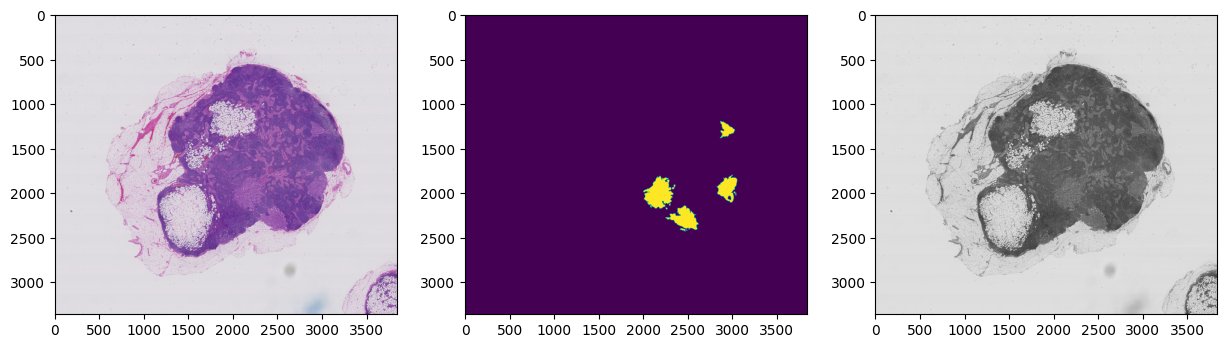

In [ ]:
# Example: read the entire slide at level 4

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=4, 
                         width=slide.level_dimensions[4][0], 
                         height=slide.level_dimensions[4][1])

# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=4, 
                        width=slide.level_dimensions[4][0], 
                        height=slide.level_dimensions[4][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

print(slide_image.shape)
tissue_pixels, gray_slide = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

f, axarr = plt.subplots(1,3, figsize=(15,15), dpi=100)
axarr[0].imshow(slide_image)
axarr[1].imshow(mask_image)
axarr[2].imshow(gray_slide, cmap=plt.get_cmap('gray'))

## Test loading image patch

2020 tissue_pixels pixels (20.2 percent of the image)


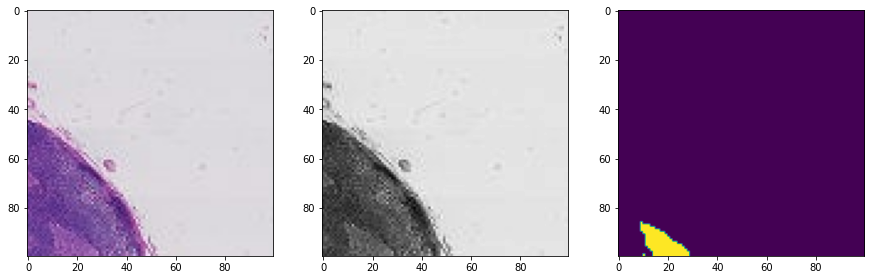

In [ ]:
test_region1 = read_slide(slide, x=350 * 128, y=64 * 128, level=7, width=100, height=100)
test_mask_region1 = read_slide(tumor_mask, x=350 * 128, y=64 * 128, level=7, width=100, height=100)[:,:,0]
tissue_pixels, gray_test_region1 = find_tissue_pixels(test_region1)
percent_tissue = len(tissue_pixels) / float(test_region1.shape[0] * test_region1.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
f, axarr = plt.subplots(1,3, figsize=(15,15))
axarr[0].imshow(test_region1)
axarr[1].imshow(gray_test_region1, cmap=plt.get_cmap('gray'))
axarr[2].imshow(test_mask_region1)

## Show two adjacent patches

In [ ]:
test_region2 = read_slide(slide, x=350 * 128, y=64 * 128 + 100*128, level=7, width=100, height=100)
test_mask_region2 = read_slide(tumor_mask, x=350 * 128, y=64 * 128 + 100*128, level=7, width=100, height=100)[:,:,0]
tissue_pixels, gray_test_region2 = find_tissue_pixels(test_region2)
percent_tissue = len(tissue_pixels) / float(test_region2.shape[0] * test_region2.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 


5367 tissue_pixels pixels (53.7 percent of the image)


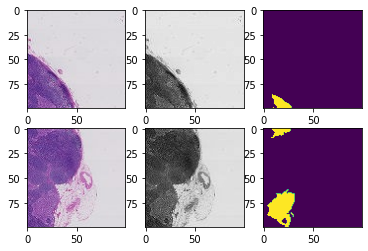

In [ ]:
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(test_region1)
axarr[0,1].imshow(gray_test_region1, cmap=plt.get_cmap('gray'))
axarr[0,2].imshow(test_mask_region1)
axarr[1,0].imshow(test_region2)
axarr[1,1].imshow(gray_test_region2, cmap=plt.get_cmap('gray'))
axarr[1,2].imshow(test_mask_region2)

## Show same patch at two different levels

In [ ]:
factor = 16
test_region3 = read_slide(slide, x=2685 * factor, y=1725 * factor, level=3, width=1000, height=1000)
test_mask_region3 = read_slide(tumor_mask, x=2685 * factor, y=1725 * factor, level=3, width=1000, height=1000)[:,:,0]
print(test_mask_region3.shape)

test_region4 = read_slide(slide, x=2685 * factor - 250*factor, y=1725 * factor - 250*factor, level=4, width=1000, height=1000)
test_mask_region4 = read_slide(tumor_mask,  x=2685 * factor - 250*factor , y=1725 * factor - 250*factor, level=4, width=1000, height=1000)[:,:,0]
print(test_mask_region4.shape)

(1000, 1000)
(1000, 1000)


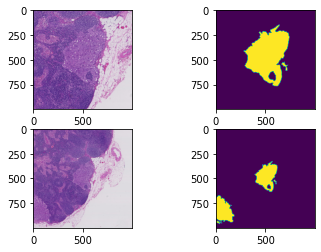

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(test_region3)
axarr[0,1].imshow(test_mask_region3)
axarr[1,0].imshow(test_region4)
axarr[1,1].imshow(test_mask_region4)

# Slide window

## Create directories for positive and negative images

In [ ]:
# create folder to save images classifications

parent_dir = "/content"
directory = "train"
zoom_level3 = "3"
zoom_level4 = "4"
positive_dir = "positive"
negative_dir = "negative"

train_path = os.path.join(parent_dir, directory)

train_path3 = os.path.join(train_path, zoom_level3)
train_path4 = os.path.join(train_path, zoom_level4)

positive_path3 = os.path.join(train_path3, positive_dir)
negative_path3 = os.path.join(train_path3, negative_dir)

positive_path4 = os.path.join(train_path4, positive_dir)
negative_path4 = os.path.join(train_path4, negative_dir)
  
if not os.path.exists(train_path):
  os.mkdir(train_path)

if not os.path.exists(train_path3):
  os.mkdir(train_path3)
if not os.path.exists(train_path4):
  os.mkdir(train_path4)

if not os.path.exists(positive_path3):
  os.mkdir(positive_path3)
if not os.path.exists(negative_path3):
  os.mkdir(negative_path3)
if not os.path.exists(positive_path4):
  os.mkdir(positive_path4)
if not os.path.exists(negative_path4):
  os.mkdir(negative_path4)

# make sure training folders are empty
for f in os.listdir(positive_path3):
  if ".png" in f:
    os.remove(os.path.join(positive_path3, f))

for f in os.listdir(negative_path3):
  if ".png" in f:
    os.remove(os.path.join(negative_path3, f))


for f in os.listdir(positive_path4):
  if ".png" in f:
    os.remove(os.path.join(positive_path4, f))

for f in os.listdir(negative_path4):
  if ".png" in f:
    os.remove(os.path.join(negative_path4, f))
 


## Test sliding window increments

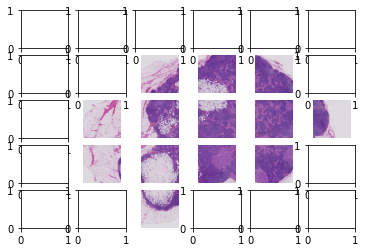

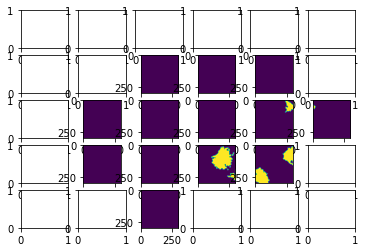

In [ ]:
import math
levels = {0:1, 1:2, 2:4, 3:8, 4:16, 5:32, 6:64, 7:128}

level = 5
threshold = 33

window_size = (299, 299)
width = window_size[1]
height = window_size[0]

cancer_window_size = (128, 128)
c_width = cancer_window_size[0]
c_height = cancer_window_size[1]

i_range = math.floor(slide.level_dimensions[level][0]/width) # increment starting xcoordinate by window width
j_range = math.floor(slide.level_dimensions[level][1]/height) # increment starting ycoordinate by window height

f, axarr = plt.subplots(j_range,i_range)
f2, axarr2 = plt.subplots(j_range,i_range)
# f2, axarr3 = plt.subplots(j_range,i_range)

start_j, end_j = 0 , j_range
start_i, end_i = 0,  i_range
for j in range(start_j, end_j):
  for i in range(start_i, end_i):
  
  # Read slide and mask at same zoom level
    slide_image = read_slide(slide, 
                            x=i*width*levels[level], 
                            y=j*height*levels[level], 
                            level=level, 
                            width=width, 
                            height=height)

    
    mask_image = read_slide(tumor_mask, 
                            x=i*width*levels[level], 
                            y=j*height*levels[level], 
                            level=level, 
                            width=width, 
                            height=height)

    mask_image = mask_image[:,:,0]

    tissue_pixels, gray = find_tissue_pixels(slide_image)
    percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100

    start_col = (width-c_width)//2
    end_col = start_col + c_width
    start_row = (height - c_height)//2
    end_row = start_row + c_height

    cancer_window = mask_image[start_row:end_row, start_col:end_col]

    # print(len(tissue_pixels), percent_tissue)
    # If no tissue cells classify as negative, otherwise check if center contains cancer cells
    if percent_tissue > threshold:
      # plot image
      axarr[j-start_j,i-start_i].imshow(slide_image)
      axarr[j-start_j,i-start_i].axis('off')
      axarr2[j-start_j,i-start_i].imshow(mask_image)

## Create path references for selected slides

In [ ]:
#select slides we want to train on
slides = ['tumor_091.tif', 'tumor_094.tif', 'tumor_101.tif', 'tumor_110.tif']
masks = ['tumor_091_mask.tif', 'tumor_094_mask.tif', 'tumor_101_mask.tif', 'tumor_110_mask.tif']

# format paths
slide_paths = []
tumor_mask_paths = []
for slide in slides:
  slide_paths.append(drive_root + slide)
for mask in masks:
  tumor_mask_paths.append(drive_root + mask)

# verify paths are correct
print(slide_paths)
print(tumor_mask_paths)

slides = [('tumor_091.tif', 'tumor_091_mask.tif'), 
          ('tumor_094.tif', 'tumor_094_mask.tif'),
          ('tumor_101.tif', 'tumor_101_mask.tif'),
          ('tumor_110.tif', 'tumor_110_mask.tif')]

slide_paths = []
for slide in slides:
  pair = (drive_root + slide[0], drive_root + slide[1])
  slide_paths.append(pair)

print(slide_paths)
print(slide_paths[0][0])
print(slide_paths[0][1])

['/content/gdrive/My Drive/COMS4995/slides2/tumor_091.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_094.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_101.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_110.tif']
['/content/gdrive/My Drive/COMS4995/slides2/tumor_091_mask.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_094_mask.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_101_mask.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_110_mask.tif']
[('/content/gdrive/My Drive/COMS4995/slides2/tumor_091.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_091_mask.tif'), ('/content/gdrive/My Drive/COMS4995/slides2/tumor_094.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_094_mask.tif'), ('/content/gdrive/My Drive/COMS4995/slides2/tumor_101.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_101_mask.tif'), ('/content/gdrive/My Drive/COMS4995/slides2/tumor_110.tif', '/content/gdrive/My Drive/COMS4995/slides2/tumor_110_mask.tif')]
/cont

## Iterate over selected slides and save regions above tissue threshold

In [ ]:
import math

levels = {0:1, 1:2, 2:4, 3:8, 4:16, 5:32, 6:64, 7:128}

level_3 = 3
level_4 = 4
threshold = 33

window_size = (299, 299)
width = window_size[1]
height = window_size[0]

cancer_window_size = (128, 128)
c_width = cancer_window_size[0]
c_height = cancer_window_size[1]

for pair in slide_paths:
  slide_path = pair[0]
  tumor_mask_path = pair[1]

  save_name = slide_path.split(".")[0].split("/")[-1] + "-"

  print(slide_path)
  print(tumor_mask_path)
  print(save_name)

  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)

  i_range = math.floor(slide.level_dimensions[level_4][0]/width) # increment starting xcoordinate by window width
  j_range = math.floor(slide.level_dimensions[level_4][1]/height) # increment starting ycoordinate by window height

  for j in range(j_range):
    for i in range(i_range):
    
    # Read slide and mask at same zoom level 4
      slide_image4 = read_slide(slide, 
                              x=i*width*levels[level_4], 
                              y=j*height*levels[level_4], 
                              level=level_4, 
                              width=width, 
                              height=height)

      
      mask_image4 = read_slide(tumor_mask, 
                              x=i*width*levels[level_4], 
                              y=j*height*levels[level_4], 
                              level=level_4, 
                              width=width, 
                              height=height)

      mask_image4 = mask_image4[:,:,0]

      # Read slide and mask at same zoom level 3
      slide_image3 = read_slide(slide, 
                              x=i*width*levels[level_4] + width//4 * levels[level_4], 
                              y=j*height*levels[level_4] + height//4 * levels[level_4], 
                              level=level_3, 
                              width=width, 
                              height=height)

      
      mask_image3 = read_slide(tumor_mask, 
                              x=i*width*levels[level_4] + width//4 * levels[level_4], 
                              y=j*height*levels[level_4] + height//4 * levels[level_4], 
                              level=level_3, 
                              width=width, 
                              height=height)

      mask_image3 = mask_image3[:,:,0]

      # calculate if this window contains any tissue cells
      tissue_pixels, gray_slide = find_tissue_pixels(slide_image3)
      percent_tissue = len(tissue_pixels) / float(slide_image3.shape[0] * slide_image3.shape[1]) * 100

      # If no tissue cells classify as negative, otherwise check if center contains cancer cells
      if percent_tissue > threshold:
        # check if center 128  x 128 has cancer cells to classify
        start_col = (width-c_width)//2
        end_col = start_col + c_width
        start_row = (height - c_height)//2
        end_row = start_row + c_height

        cancer_window = mask_image3[start_row:end_row, start_col:end_col]
        
        # if any pixel within the cancer window is a 1, mark as positive
        if any(1 in sublist for sublist in cancer_window):
          save_slide(slide_image3, positive_path3, save_name, i, j)
          save_slide(slide_image4, positive_path4, save_name, i, j)
        else:
          save_slide(slide_image3, negative_path3, save_name, i, j)
          save_slide(slide_image4, negative_path4, save_name, i, j)

        # print(i,j)

/content/gdrive/My Drive/COMS4995/slides2/tumor_091.tif
/content/gdrive/My Drive/COMS4995/slides2/tumor_091_mask.tif
tumor_091-
/content/gdrive/My Drive/COMS4995/slides2/tumor_094.tif
/content/gdrive/My Drive/COMS4995/slides2/tumor_094_mask.tif
tumor_094-
/content/gdrive/My Drive/COMS4995/slides2/tumor_101.tif
/content/gdrive/My Drive/COMS4995/slides2/tumor_101_mask.tif
tumor_101-
/content/gdrive/My Drive/COMS4995/slides2/tumor_110.tif
/content/gdrive/My Drive/COMS4995/slides2/tumor_110_mask.tif
tumor_110-


## Verify saved images

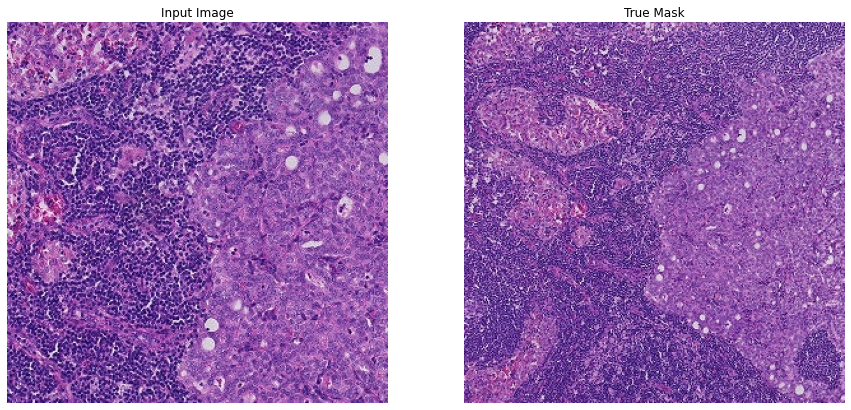

In [ ]:
test_3 = "/content/train/3/positive/tumor_091-9-6.png"
test_4 = "/content/train/4/positive/tumor_091-9-6.png"
display_images = [mpimg.imread(test_3), mpimg.imread(test_4)]
display(display_images)


# Generate labels for each image

In [ ]:
# get path for all positive and negative images
import pathlib

# zoom level 3
data_root3 = pathlib.Path(train_path3)
all_image_paths3 = list(data_root.glob('*/*.png'))
all_image_paths3 = [str(path) for path in all_image_paths3]

image_count3 = len(all_image_paths3)
print(all_image_paths3)
print(image_count3)


# zoom level 4
data_root4 = pathlib.Path(train_path4)
all_image_paths4 = list(data_root4.glob('*/*.png'))
all_image_paths4 = [str(path) for path in all_image_paths4]

image_count4 = len(all_image_paths4)
print(all_image_paths4)
print(image_count4)

['/content/train/3/positive/tumor_110-9-1.png', '/content/train/3/positive/tumor_110-9-2.png', '/content/train/3/positive/tumor_091-9-6.png', '/content/train/3/positive/tumor_101-8-5.png', '/content/train/3/positive/tumor_110-4-10.png', '/content/train/3/positive/tumor_110-4-9.png', '/content/train/3/positive/tumor_110-5-4.png', '/content/train/3/positive/tumor_110-12-3.png', '/content/train/3/positive/tumor_110-11-8.png', '/content/train/3/positive/tumor_110-6-11.png', '/content/train/3/positive/tumor_110-5-5.png', '/content/train/3/positive/tumor_110-5-12.png', '/content/train/3/positive/tumor_110-6-4.png', '/content/train/3/positive/tumor_110-12-6.png', '/content/train/3/positive/tumor_110-7-11.png', '/content/train/3/positive/tumor_110-8-3.png', '/content/train/3/positive/tumor_110-11-3.png', '/content/train/3/positive/tumor_110-3-5.png', '/content/train/3/positive/tumor_110-12-4.png', '/content/train/3/positive/tumor_110-3-6.png', '/content/train/3/positive/tumor_094-17-6.png', '/

In [ ]:
# get label name

# zoom level 3
label_names3 = sorted(item.name for item in data_root3.glob('*/') if item.is_dir())
print(label_names3)

# zoom level 4
label_names4 = sorted(item.name for item in data_root4.glob('*/') if item.is_dir())
print(label_names4)

['negative', 'positive']
['negative', 'positive']


In [ ]:
# convert to binary labels

# zoom level 3
label_to_index3 = dict((name, index) for index, name in enumerate(label_names3))
print(label_to_index3)

# zoom level 4
label_to_index4 = dict((name, index) for index, name in enumerate(label_names4))
print(label_to_index4)

{'negative': 0, 'positive': 1}
{'negative': 0, 'positive': 1}


In [ ]:
# give each image a label

# zoom level 3
all_labels3 = [label_to_index3[pathlib.Path(path).parent.name]
                    for path in all_image_paths3]

print("First 10 labels indices: ", all_labels3[:15])

# zoom level 4
all_labels4 = [label_to_index4[pathlib.Path(path).parent.name]
                    for path in all_image_paths4]

print("First 10 labels indices: ", all_labels4[:15])

First 10 labels indices:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
First 10 labels indices:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Read image pairs into training set

## Check class balance

In [ ]:
from collections import Counter

# zoom level 3
print(Counter(all_labels3).keys()) # unique labels
print(Counter(all_labels3).values()) # counts of each label

# zoom level 4
print(Counter(all_labels4).keys()) # unique labels
print(Counter(all_labels4).values()) # counts of each label

dict_keys([1, 0])
dict_values([75, 258])
dict_keys([1, 0])
dict_values([75, 258])


**Note:** The number of positive instances are less than negative, this can skew the model to just learn the majority class. For now, when we create our training set we will throw out negative cases until we get a 50:50 split. Given our minimal positive classes, later on we can use data augmentation to avoid have too small of a sample set

## Create Training/Validation/Test Set

In [ ]:
# create training and test sets
from sklearn.model_selection import train_test_split

count = len(all_image_paths3)
count_60 = math.floor(count*.6)
count_20 = math.floor(count*.2)

# zoom level 3
train_paths3 = all_image_paths3[:count_60]
test_paths3 = all_image_paths3[-count_20:]
train_labels3 = all_labels3[:count_60]
test_labels3 = all_labels3[-count_20:]
val_paths3 = all_image_paths3[count_60: -count_20]
val_labels3 = all_labels3[count_60: -count_20]

# zoom level 4
train_paths4 = all_image_paths4[:count_60]
test_paths4 = all_image_paths4[-count_20:]
train_labels4 = all_labels4[:count_60]
test_labels4 = all_labels4[-count_20:]
val_paths4 = all_image_paths4[count_60: -count_20]
val_labels4 = all_labels4[count_60: -count_20]

print(count, count_60, count_20)
print(len(train_paths3), train_paths3)
print(len(train_paths4), train_paths4)

333 199 66
199 ['/content/train/3/positive/tumor_110-9-1.png', '/content/train/3/positive/tumor_110-9-2.png', '/content/train/3/positive/tumor_091-9-6.png', '/content/train/3/positive/tumor_101-8-5.png', '/content/train/3/positive/tumor_110-4-10.png', '/content/train/3/positive/tumor_110-4-9.png', '/content/train/3/positive/tumor_110-5-4.png', '/content/train/3/positive/tumor_110-12-3.png', '/content/train/3/positive/tumor_110-11-8.png', '/content/train/3/positive/tumor_110-6-11.png', '/content/train/3/positive/tumor_110-5-5.png', '/content/train/3/positive/tumor_110-5-12.png', '/content/train/3/positive/tumor_110-6-4.png', '/content/train/3/positive/tumor_110-12-6.png', '/content/train/3/positive/tumor_110-7-11.png', '/content/train/3/positive/tumor_110-8-3.png', '/content/train/3/positive/tumor_110-11-3.png', '/content/train/3/positive/tumor_110-3-5.png', '/content/train/3/positive/tumor_110-12-4.png', '/content/train/3/positive/tumor_110-3-6.png', '/content/train/3/positive/tumor_09

In [ ]:
print(len(train_paths3), train_paths3)
print(len(train_paths4), train_paths4)
print()
print(len(val_paths3), val_paths3)
print(len(val_paths4), val_paths4)
print()
print(len(test_paths3), test_paths3)
print(len(test_paths4), test_paths4)

199 ['/content/train/3/positive/tumor_110-9-1.png', '/content/train/3/positive/tumor_110-9-2.png', '/content/train/3/positive/tumor_091-9-6.png', '/content/train/3/positive/tumor_101-8-5.png', '/content/train/3/positive/tumor_110-4-10.png', '/content/train/3/positive/tumor_110-4-9.png', '/content/train/3/positive/tumor_110-5-4.png', '/content/train/3/positive/tumor_110-12-3.png', '/content/train/3/positive/tumor_110-11-8.png', '/content/train/3/positive/tumor_110-6-11.png', '/content/train/3/positive/tumor_110-5-5.png', '/content/train/3/positive/tumor_110-5-12.png', '/content/train/3/positive/tumor_110-6-4.png', '/content/train/3/positive/tumor_110-12-6.png', '/content/train/3/positive/tumor_110-7-11.png', '/content/train/3/positive/tumor_110-8-3.png', '/content/train/3/positive/tumor_110-11-3.png', '/content/train/3/positive/tumor_110-3-5.png', '/content/train/3/positive/tumor_110-12-4.png', '/content/train/3/positive/tumor_110-3-6.png', '/content/train/3/positive/tumor_094-17-6.png'

### Check Training set balance

In [ ]:
# zoom level 3
print(Counter(train_labels3).keys()) # unique labels
print(Counter(train_labels3).values()) # counts of each label

# zoom level 4
print(Counter(train_labels4).keys()) # unique labels
print(Counter(train_labels4).values()) # counts of each label

dict_keys([1, 0])
dict_values([75, 124])
dict_keys([1, 0])
dict_values([75, 124])


### Rebalance training set

In [ ]:
# reduce majority class until it equals minority class

negative_count = sum(1 if x==0 else 0 for x in train_labels3)
positive_count = sum(1 if x==1 else 0 for x in train_labels3)

minority_class = 1 if positive_count < negative_count else 0
majority_class = 0 if positive_count < negative_count else 1

# of datapoints to remove
total = min(negative_count, positive_count)

train_paths_l3 = []
train_labels_l3 = []

train_paths_l4 = []
train_labels_l4 = []

count = 0
for i in range(len(train_labels3)):
  if train_labels3[i] == minority_class:
    # zoom level 3
    train_paths_l3.append(train_paths3[i])
    train_labels_l3.append(train_labels3[i])

    # zoom level 4
    train_paths_l4.append(train_paths4[i])
    train_labels_l4.append(train_labels4[i])
  elif count < total:
    # zoom level 3
    train_paths_l3.append(train_paths3[i])
    train_labels_l3.append(train_labels3[i])

    # zoom level 4
    train_paths_l4.append(train_paths4[i])
    train_labels_l4.append(train_labels4[i])

    count += 1

# zoom level 3
train_labels3 = train_labels_l3
train_paths3 = train_paths_l3

# zoom level 4
train_labels4 = train_labels_l4
train_paths4 = train_paths_l4

In [ ]:
# Check new balance

# zoom level 3
print(train_paths3)
print(Counter(train_labels3).keys()) # unique labels
print(Counter(train_labels3).values()) # counts of each label

# zoom level 4
print(train_paths4)
print(Counter(train_labels4).keys()) # unique labels
print(Counter(train_labels4).values()) # counts of each label

['/content/train/3/positive/tumor_110-9-1.png', '/content/train/3/positive/tumor_110-9-2.png', '/content/train/3/positive/tumor_091-9-6.png', '/content/train/3/positive/tumor_101-8-5.png', '/content/train/3/positive/tumor_110-4-10.png', '/content/train/3/positive/tumor_110-4-9.png', '/content/train/3/positive/tumor_110-5-4.png', '/content/train/3/positive/tumor_110-12-3.png', '/content/train/3/positive/tumor_110-11-8.png', '/content/train/3/positive/tumor_110-6-11.png', '/content/train/3/positive/tumor_110-5-5.png', '/content/train/3/positive/tumor_110-5-12.png', '/content/train/3/positive/tumor_110-6-4.png', '/content/train/3/positive/tumor_110-12-6.png', '/content/train/3/positive/tumor_110-7-11.png', '/content/train/3/positive/tumor_110-8-3.png', '/content/train/3/positive/tumor_110-11-3.png', '/content/train/3/positive/tumor_110-3-5.png', '/content/train/3/positive/tumor_110-12-4.png', '/content/train/3/positive/tumor_110-3-6.png', '/content/train/3/positive/tumor_094-17-6.png', '/

## Verify images

/content/train/3/positive/tumor_110-7-3.png
positive
/content/gdrive/My Drive/COMS4995/slides2/tumor_110_mask.tif


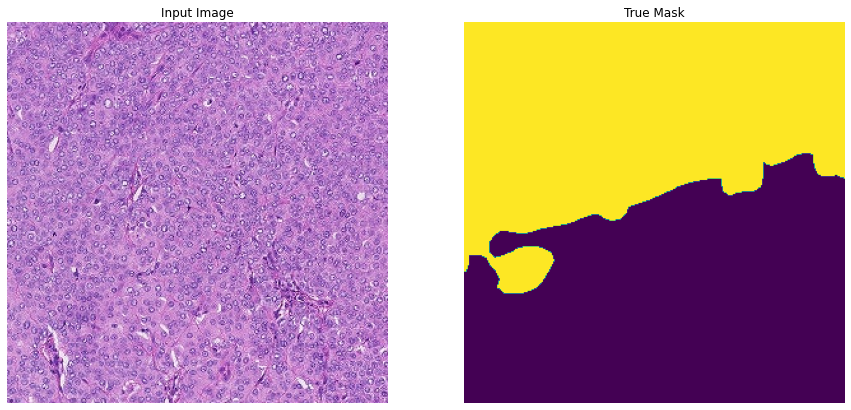

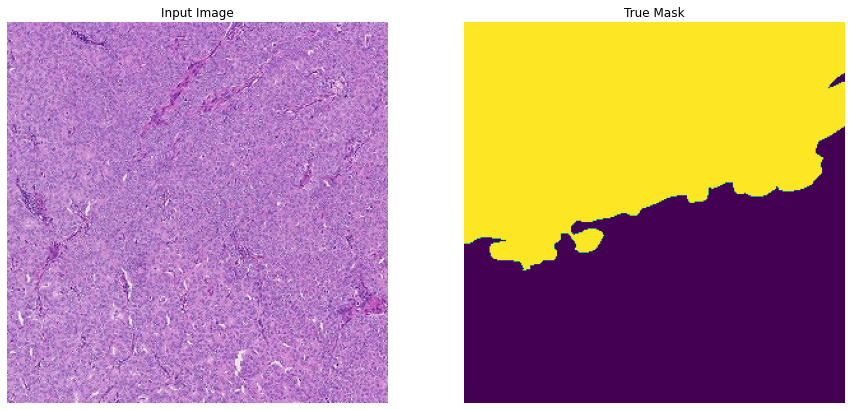


/content/train/3/negative/tumor_101-10-3.png
negative
/content/gdrive/My Drive/COMS4995/slides2/tumor_101_mask.tif


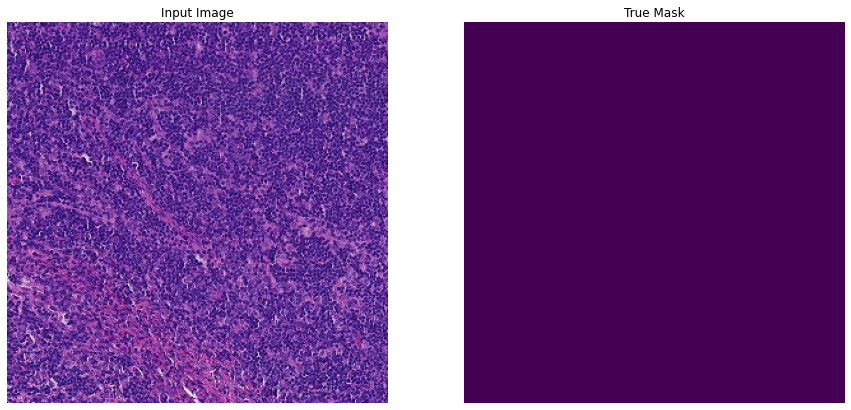

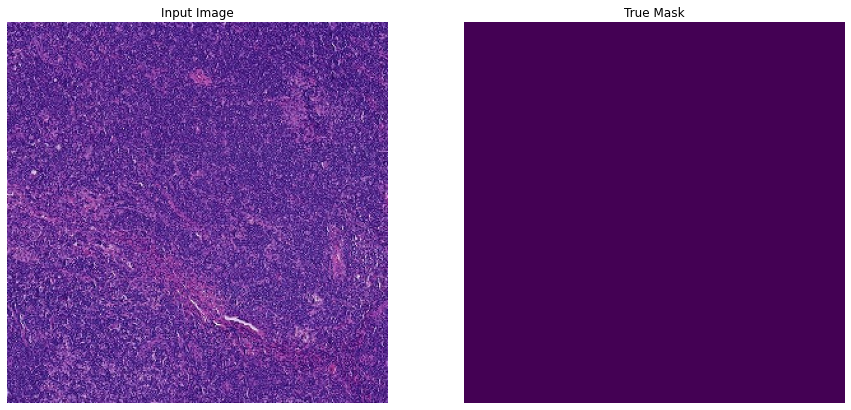


/content/train/3/negative/tumor_094-14-8.png
negative
/content/gdrive/My Drive/COMS4995/slides2/tumor_094_mask.tif


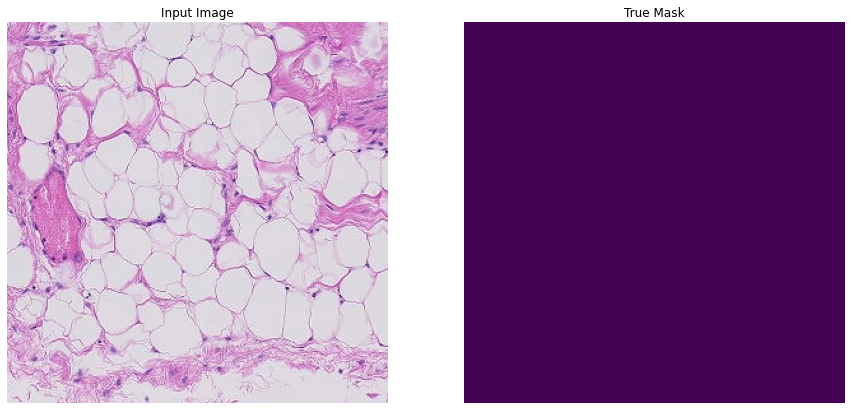

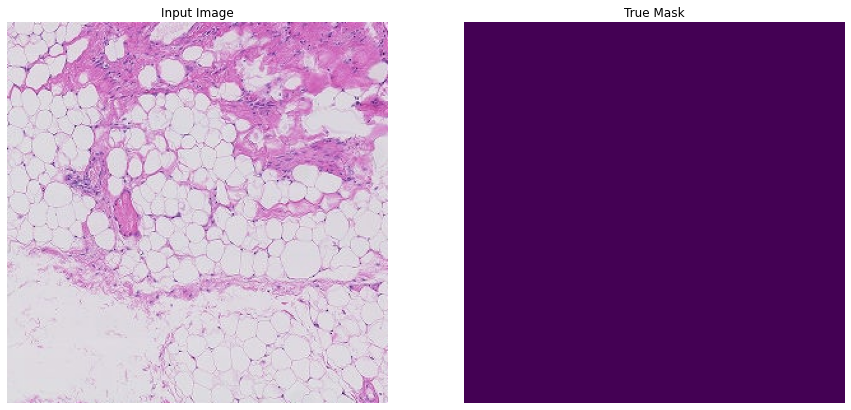

In [ ]:
# Display some images with their labels
import random
import IPython
# import IPython.display as display

for n in range(3):
  k = random.randint(0,len(train_paths3))
  # print(i)
  image_path3 = train_paths3[k]
  image_path4 = train_paths4[k]
  print(train_paths3[k])
  print(label_names3[train_labels3[k]])
  # display.display(display.Image(image_path))
  

  split_path3 =  train_paths3[k].split("-")
  split_path4 =  train_paths4[k].split("-")
  tumor_mask_path3 = drive_root + split_path3[0].split("/")[-1] + "_mask.tif"
  tumor_mask_path4 = drive_root + split_path4[0].split("/")[-1] + "_mask.tif"
  print(tumor_mask_path3)
  i = int(split_path[1])
  j = int(split_path[2].split(".")[0])


  tumor_mask3 = open_slide(tumor_mask_path3)
  mask_image3 = read_slide(tumor_mask3, 
                            x=i*width*levels[level_4]  + width//4 * levels[level_4], 
                            y=j*height*levels[level_4]  + height//4 * levels[level_4], 
                            level=level_3, 
                            width=width, 
                            height=height)

  mask_image3 = mask_image3[:,:,0]

  tumor_mask4 = open_slide(tumor_mask_path4)
  mask_image4 = read_slide(tumor_mask4, 
                            x=i*width*levels[level_4], 
                            y=j*height*levels[level_4], 
                            level=level_4, 
                            width=width, 
                            height=height)

  mask_image4 = mask_image4[:,:,0]

  display_images = [mpimg.imread(image_path3), mask_image3]
  display(display_images)
  display_images = [mpimg.imread(image_path4), mask_image4]
  display(display_images)

  print()

# Begin using TensorFlow ops to read and decode the images

In [ ]:
# create functions to read and preprocess images
def load_and_preprocess_image(path3, path4):
  img3 = tf.io.read_file(path3)
  img3 = tf.image.decode_jpeg(img3, channels=3)
  img3 = tf.image.resize(img3, window_size)
  img3 /= 255.0  # normalize pixels to 0,1

  img4 = tf.io.read_file(path4)
  img4 = tf.image.decode_jpeg(img4, channels=3)
  img4 = tf.image.resize(img4, window_size)
  img4 /= 255.0  # normalize pixels to 0,1
  return img3, img4

def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

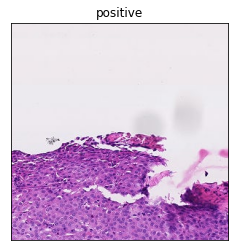

In [ ]:
# zoom level 3
img_path3 = train_paths3[0]
img = load_and_preprocess_image(img_path3)
label = label_names3[train_labels3[0]]
show(img, label)

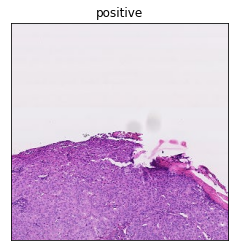

In [ ]:
# zoom level 4
img_path4 = train_paths4[0]
img = load_and_preprocess_image(img_path4)
label = label_names4[train_labels4[0]]
show(img, label)

### Build an input pipeline to return images and labels

In [ ]:
# a dataset that returns image paths

# zoom level 3
# training dataset
print("Training set")
train_path_ds3 = tf.data.Dataset.from_tensor_slices(train_paths3)
for n, img_path in enumerate(train_path_ds3.take(4)):
  print(n, img_path)

# validation dataset
print("Validation set")
val_path_ds3 = tf.data.Dataset.from_tensor_slices(val_paths3)
for n, img_path in enumerate(val_path_ds3.take(4)):
  print(n, img_path)


# zoom level 4
# training dataset
print("Training set")
train_path_ds4 = tf.data.Dataset.from_tensor_slices(train_paths4)
for n, img_path in enumerate(train_path_ds4.take(4)):
  print(n, img_path)

# validation dataset
print("Validation set")
val_path_ds4 = tf.data.Dataset.from_tensor_slices(val_paths4)
for n, img_path in enumerate(val_path_ds4.take(4)):
  print(n, img_path)

Training set
0 tf.Tensor(b'/content/train/3/positive/tumor_110-9-1.png', shape=(), dtype=string)
1 tf.Tensor(b'/content/train/3/positive/tumor_110-9-2.png', shape=(), dtype=string)
2 tf.Tensor(b'/content/train/3/positive/tumor_091-9-6.png', shape=(), dtype=string)
3 tf.Tensor(b'/content/train/3/positive/tumor_101-8-5.png', shape=(), dtype=string)
Validation set
0 tf.Tensor(b'/content/train/3/negative/tumor_101-5-4.png', shape=(), dtype=string)
1 tf.Tensor(b'/content/train/3/negative/tumor_094-7-4.png', shape=(), dtype=string)
2 tf.Tensor(b'/content/train/3/negative/tumor_091-4-6.png', shape=(), dtype=string)
3 tf.Tensor(b'/content/train/3/negative/tumor_110-10-5.png', shape=(), dtype=string)
Training set
0 tf.Tensor(b'/content/train/4/positive/tumor_110-9-1.png', shape=(), dtype=string)
1 tf.Tensor(b'/content/train/4/positive/tumor_110-9-2.png', shape=(), dtype=string)
2 tf.Tensor(b'/content/train/4/positive/tumor_091-9-6.png', shape=(), dtype=string)
3 tf.Tensor(b'/content/train/4/pos

In [ ]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)

# zoom level 3
# training dataset
print("Training set")
train_image_ds3 = train_path_ds3.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(train_image_ds3.take(4)):
  print(n, image.shape)

# validation dataset
print("Validation set")
val_image_ds3 = val_path_ds3.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(val_image_ds3.take(4)):
  print(n, image.shape)


# zoom level 4
# training dataset
print("Training set")
train_image_ds4 = train_path_ds4.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(train_image_ds4.take(4)):
  print(n, image.shape)

# validation dataset
print("Validation set")
val_image_ds4 = val_path_ds4.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(val_image_ds4.take(4)):
  print(n, image.shape)

Training set
0 (299, 299, 3)
1 (299, 299, 3)
2 (299, 299, 3)
3 (299, 299, 3)
Validation set
0 (299, 299, 3)
1 (299, 299, 3)
2 (299, 299, 3)
3 (299, 299, 3)
Training set
0 (299, 299, 3)
1 (299, 299, 3)
2 (299, 299, 3)
3 (299, 299, 3)
Validation set
0 (299, 299, 3)
1 (299, 299, 3)
2 (299, 299, 3)
3 (299, 299, 3)


In [ ]:
# a dataset that returns labels

# zoom level 3
#training dataset
print("Training set")
train_label_ds3 = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels3, tf.int64))
for label in train_label_ds3.take(4):
  print(label_names3[label.numpy()])

#validation dataset
print("Validation set")
val_label_ds3 = tf.data.Dataset.from_tensor_slices(tf.cast(val_labels3, tf.int64))
for label in val_label_ds3.take(4):
  print(label_names3[label.numpy()])


# zoom level 4
#training dataset
print("Training set")
train_label_ds4 = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels4, tf.int64))
for label in train_label_ds4.take(4):
  print(label_names4[label.numpy()])

#validation dataset
print("Validation set")
val_label_ds4 = tf.data.Dataset.from_tensor_slices(tf.cast(val_labels4, tf.int64))
for label in val_label_ds4.take(4):
  print(label_names4[label.numpy()])

Training set
positive
positive
positive
positive
Validation set
negative
negative
negative
negative
Training set
positive
positive
positive
positive
Validation set
negative
negative
negative
negative


In [ ]:
# a dataset that returns images and labels

# # ORIGINAL
# # training dataset
# print("Training set")
# train_image_label_ds3 = tf.data.Dataset.zip((train_image_ds3, train_label_ds3))
# print(train_image_label_ds3)

# # validation dataset
# print("Validation set")
# val_image_label_ds = tf.data.Dataset.zip((val_image_ds, val_label_ds))
# print(val_image_label_ds)

<ZipDataset shapes: ((299, 299, 3), ()), types: (tf.float32, tf.int64)>
<ZipDataset shapes: ((299, 299, 3), ()), types: (tf.float32, tf.int64)>


In [ ]:
# a dataset that returns images and labels
dataset_34 = tf.data.Dataset.from_tensor_slices((train_paths3, train_paths4))
train_image_ds34 = dataset_34.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
print(train_image_ds34)

dataset_label = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels3, tf.int64))
print(dataset_label)

dataset = tf.data.Dataset.zip((train_image_ds34, dataset_label))
print(dataset)

<ParallelMapDataset shapes: ((299, 299, 3), (299, 299, 3)), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: (), types: tf.int64>
<ZipDataset shapes: (((299, 299, 3), (299, 299, 3)), ()), types: ((tf.float32, tf.float32), tf.int64)>


## Batch and shuffle

In [ ]:
# # ORIGINAL
# # training dataset
# print("Training set")
# train_ds = train_image_label_ds.shuffle(SHUFFLE_SIZE)
# train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# for img, label in train_ds.take(2):
#   print(img.shape, label.shape) # notice it's returning batches of data now

# # validation dataset
# print("Validation set")
# val_ds = val_image_label_ds.shuffle(SHUFFLE_SIZE)
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# for img, label in val_ds.take(2):
#   print(img.shape, label.shape) # notice it's returning batches of data now

(32, 299, 299, 3) (32,)
(32, 299, 299, 3) (32,)
(32, 299, 299, 3) (32,)
(32, 299, 299, 3) (32,)


In [ ]:
# NEW
# training dataset
print("Training set")
# print(train_image_ds34)
# train_image_ds_final = train_image_ds34.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# print(train_image_ds_final)
# # print(train_image_ds32.take(1))
# for img3, img4 in train_image_ds_final:
#   print(img3.shape, img4.shape)

# dataset_label_final = dataset_label.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# print(dataset_label_final)
# # print(train_image_ds32.take(1))
# for label in dataset_label_final:
#   print(label.shape)

dataset_final = dataset.shuffle(SHUFFLE_SIZE)
dataset_final = dataset_final.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print(dataset_final)
for data1, data2 in dataset_final:
  print(data1[0].shape, data1[1].shape, data2.shape)

Training set
<PrefetchDataset shapes: (((None, 299, 299, 3), (None, 299, 299, 3)), (None,)), types: ((tf.float32, tf.float32), tf.int64)>
(32, 299, 299, 3) (32, 299, 299, 3) (32,)
(32, 299, 299, 3) (32, 299, 299, 3) (32,)
(32, 299, 299, 3) (32, 299, 299, 3) (32,)
(32, 299, 299, 3) (32, 299, 299, 3) (32,)
(22, 299, 299, 3) (22, 299, 299, 3) (22,)


# Create Model

In [ ]:
IMG_SHAPE = (299, 299, 3)


# define the base model for level 3
inputs3 = tf.keras.Input(IMG_SHAPE)
base_model3 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') 

base_model3.trainable = False 

x3 = base_model3(inputs3)
x3 = tf.keras.layers.Flatten()(x3)
x3 = tf.keras.layers.Dense(128, activation='relu')(x3)
# x3 = tf.keras.layers.Dense(1, activation='sigmoid')(x3)

# define the base model for level 4
inputs4 = tf.keras.Input(IMG_SHAPE)
base_model4 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') 
base_model4._name = "InceptionV3_L4"
base_model4.trainable = False 

x4 = base_model4(inputs4)
x4 = tf.keras.layers.Flatten()(x4)
x4 = tf.keras.layers.Dense(128, activation='relu')(x4)
# x4 = tf.keras.layers.Dense(1, activation='sigmoid')(x4)


# combine results
merged = tf.keras.layers.concatenate([x3, x4])
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)


model = tf.keras.Model(inputs=[inputs3, inputs4], outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 8, 8, 2048)   21802784    input_29[0][0]                   
__________________________________________________________________________________________________
InceptionV3_L4 (Functional)     (None, 8, 8, 2048)   21802784    input_31[0][0]                   
____________________________________________________________________________________________

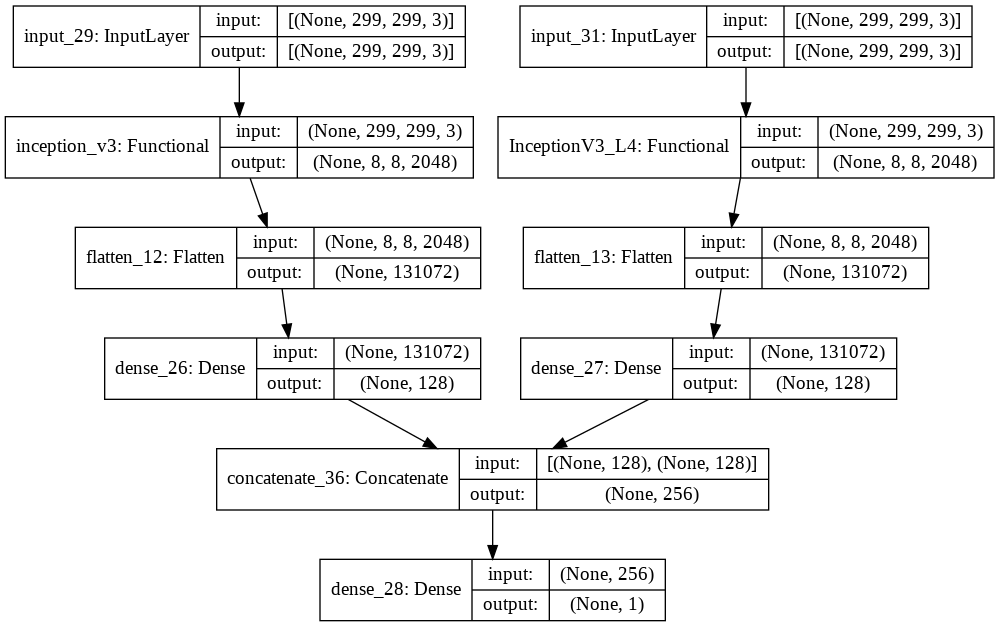

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

## Train Model

In [ ]:
history = model.fit(dataset_final, epochs=3)

Epoch 1/3
5/5 [==============================] - 66s 11s/step - loss: 23.0633 - accuracy: 0.5284
Epoch 2/3
5/5 [==============================] - 55s 11s/step - loss: 0.7221 - accuracy: 0.9157
Epoch 3/3
5/5 [==============================] - 55s 11s/step - loss: 0.0429 - accuracy: 0.9869


In [ ]:
model.evaluate(val_ds)

9/9 [==============================] - 54s 6s/step - loss: 1.2709 - accuracy: 0.9067


[1.2709232568740845, 0.9067164063453674]

## Make a prediction

Batch predictions: [[1.]]
Label predictions: [1]
Prediction positive
Actual positive
/content/gdrive/My Drive/COMS4995/slides2/tumor_110_mask.tif
tumor_110_mask.tif 7 2


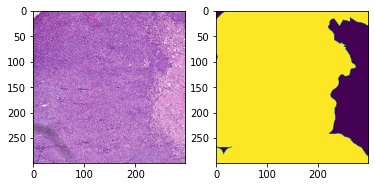

In [ ]:
# load an image off disk
img_index = 26
img3, img4 = load_and_preprocess_image(train_paths3[img_index], train_paths4[img_index])


# im_batch = tf.expand_dims(input=[img3, img4], axis=0) # use tf.expand_dims
# im_batch = tf.data.Dataset.zip((img3, img4))
img3 = tf.expand_dims(img3, axis=0)
img4 = tf.expand_dims(img4, axis=0)
im_batch = [img3, img4]


# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
print("Batch predictions:", batch_pred)
pred = batch_pred[0] 


pred = tf.where(pred < 0.5, 0, 1)
print("Label predictions:",pred.numpy())
print("Prediction", label_names4[pred.numpy()[0]])
print("Actual", label_names4[train_labels4[img_index]])


split_path =  train_paths4[img_index].split("-")
tumor = split_path[0].split("/")[-1] + "_mask.tif" 
tumor_mask_path4 = drive_root + tumor
print(tumor_mask_path)
tumor_mask4 = open_slide(tumor_mask_path4)

i = int(split_path[1])
j = int(split_path[2].split(".")[0])
print(tumor, i,j)

mask_image4 = read_slide(tumor_mask4, 
                              x=i*width*levels[level_4], 
                              y=j*height*levels[level_4], 
                              level=level_4, 
                              width=width, 
                              height=height)

mask_image4 = mask_image4[:,:,0]

slide_image = mpimg.imread(train_paths4[img_index])


plt.subplot(1, 2, 1)
plt.imshow(slide_image)
plt.subplot(1, 2, 2)
plt.imshow(mask_image4)
plt.show()

### See all predictions

In [ ]:
# # see all predictions

# for img_index in range(len(train_paths)):
#   img = load_and_preprocess_image(train_paths[img_index])
#   im_batch = tf.expand_dims(img, axis=0) # use tf.expand_dims

#   # print(im_batch.shape) # after

#   # make predictions
#   batch_pred = model.predict(im_batch) # returns a list of predictions
#   print("Batch predictions:", batch_pred)
#   pred = batch_pred[0] 
#   pred = tf.where(pred < 0.5, 0, 1)
#   print("Label predictions:",pred.numpy())

#   print("Prediction", label_names[pred.numpy()[0]])
#   print("Actual", label_names[train_labels[img_index]])

#   split_path =  train_paths[img_index].split("-")

#   tumor = split_path[0].split("/")[-1] + "_mask.tif" 
#   tumor_mask_path = drive_root + tumor
#   tumor_mask = open_slide(tumor_mask_path)

#   i = int(split_path[1])
#   j = int(split_path[2].split(".")[0])
#   print(tumor, i,j)


#   mask_image = read_slide(tumor_mask, 
#                               x=i*width*levels[level], 
#                               y=j*height*levels[level], 
#                               level=level, 
#                               width=width, 
#                               height=height)

#   mask_image = mask_image[:,:,0]

#   slide_image = mpimg.imread(train_paths[img_index])

Batch predictions: [[0.]]
Label predictions: [0]
Prediction negative
Actual negative
tumor_101_mask.tif 41 18
Batch predictions: [[1.80518e-30]]
Label predictions: [0]
Prediction negative
Actual negative
tumor_101_mask.tif 8 11
Batch predictions: [[0.]]
Label predictions: [0]
Prediction negative
Actual negative
tumor_094_mask.tif 40 6
Batch predictions: [[1.5960987e-33]]
Label predictions: [0]
Prediction negative
Actual negative
tumor_110_mask.tif 15 16
Batch predictions: [[1.3120821e-28]]
Label predictions: [0]
Prediction negative
Actual negative
tumor_094_mask.tif 15 20
Batch predictions: [[1.]]
Label predictions: [1]
Prediction positive
Actual positive
tumor_091_mask.tif 20 12
Batch predictions: [[4.050083e-18]]
Label predictions: [0]
Prediction negative
Actual negative
tumor_091_mask.tif 16 8
Batch predictions: [[1.]]
Label predictions: [1]
Prediction positive
Actual positive
tumor_110_mask.tif 17 5
Batch predictions: [[2.980102e-22]]
Label predictions: [0]
Prediction negative
Actu

## See predictions using direct slide rather than saved path

(299, 299, 3)
0.0
1.0
(299, 299, 3)
0.0
1.0
Batch predictions: [[1.]]
Label predictions: [1]
Prediction positive
Actual positive


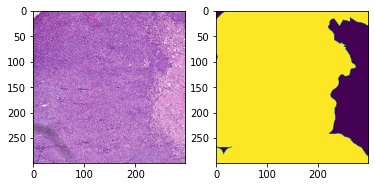

In [ ]:
# load an image off disk

slide_path = 'tumor_110.tif' # only this file is available
tumor_mask_path = 'tumor_110_mask.tif' # only this file is available

slide_path = drive_root + slide_path
tumor_mask_path = drive_root + tumor_mask_path


slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

i, j = 7,2


# Read slide and mask at same zoom level 4
img4 = read_slide(slide, 
                        x=i*width*levels[level_4], 
                        y=j*height*levels[level_4], 
                        level=level_4, 
                        width=width, 
                        height=height)

img4 = img4/255.0
print(img4.shape) # before
print(img4.min())
print(img4.max())

slide_image = img4

# Read slide and mask at same zoom level 3
img3 = read_slide(slide, 
                        x=i*width*levels[level_4] + width//4 * levels[level_4], 
                        y=j*height*levels[level_4] + height//4 * levels[level_4], 
                        level=level_3, 
                        width=width, 
                        height=height)

img3 = img3/255.0
print(img3.shape) # before
print(img3.min())
print(img3.max())


img3 = tf.expand_dims(img3, axis=0)
img4 = tf.expand_dims(img4, axis=0)
im_batch = [img3, img4]


# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
print("Batch predictions:", batch_pred)
pred = batch_pred[0] 
pred = tf.where(pred < 0.5, 0, 1)
print("Label predictions:",pred.numpy())
print("Prediction", label_names4[pred.numpy()[0]])

mask_image4 = read_slide(tumor_mask, 
                              x=i*width*levels[level_4], 
                              y=j*height*levels[level_4], 
                              level=level_4, 
                              width=width, 
                              height=height)

mask_image4 = mask_image4[:,:,0]


mask_image3 = read_slide(tumor_mask, 
                              x=i*width*levels[level_4] + width//4 * levels[level_4], 
                              y=j*height*levels[level_4] + height//4 * levels[level_4], 
                              level=level_3, 
                              width=width, 
                              height=height)

mask_image3 = mask_image3[:,:,0]

# calculate what actual label is
cancer_window_size = (128, 128)
c_width = cancer_window_size[0]
c_height = cancer_window_size[1]

# check if center 128  x 128 has cancer cells to classify
start_col = (width-c_width)//2
end_col = start_col + c_width
start_row = (height - c_height)//2
end_row = start_row + c_height


cancer_window = mask_image3[start_row:end_row, start_col:end_col]

# if any pixel within the cancer window is a 1, mark as positive
if any(1 in sublist for sublist in cancer_window):
  label = 1
else:
  label = 0
print("Actual", label_names4[label])



f, axarr = plt.subplots(1,2)
axarr[0].imshow(slide_image)
axarr[1].imshow(mask_image4)

# Create heatmap

## Tumor 094 level = 3

### Generate predictions and assign label to each square

In [ ]:
squares = {}

slide_path = 'tumor_094.tif' # only this file is available
tumor_mask_path = 'tumor_094_mask.tif' # only this file is available

slide_path = drive_root + slide_path
tumor_mask_path = drive_root + tumor_mask_path


slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

levels = {0:1, 1:2, 2:4, 3:8, 4:16, 5:32, 6:64, 7:128}

level = 3
threshold = 33

window_size = (299, 299)
width = window_size[1]
height = window_size[0]

i_range = math.floor(slide.level_dimensions[level_4][0]/width) # increment starting xcoordinate by window width
j_range = math.floor(slide.level_dimensions[level_4][1]/height) # increment starting ycoordinate by window height


# np.full((j_range, i_range), np.zeros((height, width)))
for j in range(j_range):
  squares[j] = {}
  for i in range(i_range):

  # Read slide and mask at same zoom level 4
    slide_image4 = read_slide(slide, 
                            x=i*width*levels[level_4], 
                            y=j*height*levels[level_4], 
                            level=level_4, 
                            width=width, 
                            height=height)

    slide_image4 = slide_image4/255.0

    # Read slide and mask at same zoom level 3
    slide_image3 = read_slide(slide, 
                            x=i*width*levels[level_4] + width//4 * levels[level_4], 
                            y=j*height*levels[level_4] + height//4 * levels[level_4], 
                            level=level_3, 
                            width=width, 
                            height=height)

    slide_image3 = slide_image3/255.0


    


    # calculate if this window contains any tissue cells
    tissue_pixels, gray_slide = find_tissue_pixels(slide_image4)
    percent_tissue = len(tissue_pixels) / float(slide_image4.shape[0] * slide_image4.shape[1]) * 100

    # If no tissue cells classify as negative, otherwise check if center contains cancer cells
    if percent_tissue < threshold:
      square = np.full((height, width), 0)
    else: 
      slide_image3 = tf.expand_dims(slide_image3, axis=0)
      slide_image4 = tf.expand_dims(slide_image4, axis=0)
      im_batch = [slide_image3, slide_image4]
      # print(im_batch.shape)
      # make predictions
      batch_pred = model.predict(im_batch) # returns a list of predictions
      # print("Batch predictions:", batch_pred)
      pred = batch_pred[0] 
      pred = tf.where(pred < 0.5, 0, 1)
      print("Label predictions:",pred.numpy())
      square = np.full((height, width), pred.numpy()[0])
     
    squares[j][i] = square
    # print(i,j)

# print(squares[0][0])

Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [1]
Label predictions: [1]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [1]
Label predictions: [0]
Label predictions: [0]
Label predictions: [1]
Label predictions: [1]
Label predictions: [0]
Label predictions: [0]
Label predi

### Combine squares to one array

In [ ]:
horizontal = {} # list of row by squares
for j in range(j_range):
  first = squares[j][0] # select first square in row
  for i in range(1,i_range):
    second = squares[j][i]
    first = np.hstack((first, second)) # combine arrays within same row
  # store each combined horizontal row
  horizontal[j] = first

first = horizontal[0] # select first stacked row
for j in range(1, j_range):
  second = horizontal[j]
  first = np.vstack((first, second)) # combine arrays vertically


In [ ]:
# show new array
print(squares[0][0].shape)
print(i_range)
print(len(squares[0]))
print(horizontal[0].shape)
print(j_range)
print(first.shape)
print(first)

(299, 299)
24
24
(299, 7176)
20
(5980, 7176)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Display heatmap

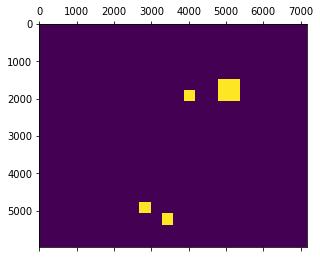

In [ ]:
plt.matshow(first)
plt.show()

In [ ]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level_4, 
                         width=slide.level_dimensions[level_4][0], 
                         height=slide.level_dimensions[level_4][1])

# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level_4, 
                        width=slide.level_dimensions[level_4][0], 
                        height=slide.level_dimensions[level_4][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

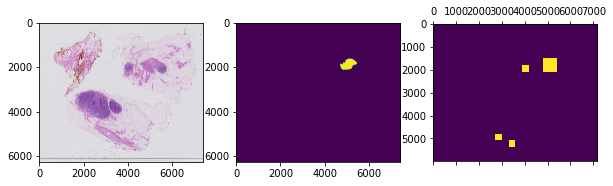

In [ ]:
# fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 1

f, axarr = plt.subplots(1,3, figsize = (10,10)) 
axarr[0].imshow(slide_image)
axarr[1].imshow(mask_image)
axarr[2].matshow(first)

## Tumor 91 level = 3

### Generate predictions and assign label to each square

In [ ]:
squares = {}

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_path = drive_root + slide_path
tumor_mask_path = drive_root + tumor_mask_path


slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

levels = {0:1, 1:2, 2:4, 3:8, 4:16, 5:32, 6:64, 7:128}

level = 3
threshold = 33

window_size = (299, 299)
width = window_size[1]
height = window_size[0]

print(slide.level_dimensions[level][0])
print(slide.level_dimensions[level][1])


i_range = math.floor(slide.level_dimensions[level_4][0]/width) # increment starting xcoordinate by window width
j_range = math.floor(slide.level_dimensions[level_4][1]/height) # increment starting ycoordinate by window height


# np.full((j_range, i_range), np.zeros((height, width)))
for j in range(j_range):
  squares[j] = {}
  for i in range(i_range):

  # Read slide and mask at same zoom level 4
    slide_image4 = read_slide(slide, 
                            x=i*width*levels[level_4], 
                            y=j*height*levels[level_4], 
                            level=level_4, 
                            width=width, 
                            height=height)

    slide_image4 = slide_image4/255.0

    # Read slide and mask at same zoom level 3
    slide_image3 = read_slide(slide, 
                            x=i*width*levels[level_4] + width//4 * levels[level_4], 
                            y=j*height*levels[level_4] + height//4 * levels[level_4], 
                            level=level_3, 
                            width=width, 
                            height=height)

    slide_image3 = slide_image3/255.0


    


    # calculate if this window contains any tissue cells
    tissue_pixels, gray_slide = find_tissue_pixels(slide_image4)
    percent_tissue = len(tissue_pixels) / float(slide_image4.shape[0] * slide_image4.shape[1]) * 100

    # If no tissue cells classify as negative, otherwise check if center contains cancer cells
    if percent_tissue < threshold:
      square = np.full((height, width), 0)
    else: 
      slide_image3 = tf.expand_dims(slide_image3, axis=0)
      slide_image4 = tf.expand_dims(slide_image4, axis=0)
      im_batch = [slide_image3, slide_image4]
      # print(im_batch.shape)
      # make predictions
      batch_pred = model.predict(im_batch) # returns a list of predictions
      # print("Batch predictions:", batch_pred)
      pred = batch_pred[0] 
      pred = tf.where(pred < 0.5, 0, 1)
      print("Label predictions:",pred.numpy())
      square = np.full((height, width), pred.numpy()[0])
     
    squares[j][i] = square
    # print(i,j)

# print(squares[0][0])

7680
6720
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [1]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [1]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [1]
Label predictions: [0]
Label predictions: [1]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]


### Combine squares to one array

In [ ]:
horizontal = {} # list of row by squares
for j in range(j_range):
  first = squares[j][0] # select first square in row
  for i in range(1,i_range):
    second = squares[j][i]
    first = np.hstack((first, second)) # combine arrays within same row
  # store each combined horizontal row
  horizontal[j] = first

first = horizontal[0] # select first stacked row
for j in range(1, j_range):
  second = horizontal[j]
  first = np.vstack((first, second)) # combine arrays vertically


In [ ]:
# show new array
print(squares[0][0].shape)
print(i_range)
print(len(squares[0]))
print(horizontal[0].shape)
print(j_range)
print(first.shape)
print(first)

(299, 299)
12
12
(299, 3588)
11
(3289, 3588)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Display heatmap

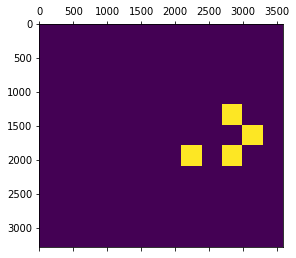

In [ ]:
plt.matshow(first)
plt.show()

In [ ]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level_4, 
                         width=slide.level_dimensions[level_4][0], 
                         height=slide.level_dimensions[level_4][1])

# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level_4, 
                        width=slide.level_dimensions[level_4][0], 
                        height=slide.level_dimensions[level_4][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

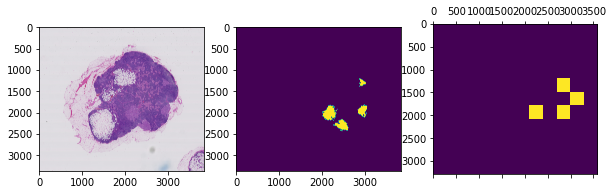

In [ ]:
# fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 1

f, axarr = plt.subplots(1,3, figsize = (10,10)) 
axarr[0].imshow(slide_image)
axarr[1].imshow(mask_image)
axarr[2].matshow(first)

## Tumor 110 level = 3

### Generate predictions and assign label to each square

In [ ]:
squares = {}

slide_path = 'tumor_110.tif' # only this file is available
tumor_mask_path = 'tumor_110_mask.tif' # only this file is available

slide_path = drive_root + slide_path
tumor_mask_path = drive_root + tumor_mask_path


slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

levels = {0:1, 1:2, 2:4, 3:8, 4:16, 5:32, 6:64, 7:128}

level = 3
threshold = 33

window_size = (299, 299)
width = window_size[1]
height = window_size[0]

print(slide.level_dimensions[level][0])
print(slide.level_dimensions[level][1])


i_range = math.floor(slide.level_dimensions[level_4][0]/width) # increment starting xcoordinate by window width
j_range = math.floor(slide.level_dimensions[level_4][1]/height) # increment starting ycoordinate by window height


# np.full((j_range, i_range), np.zeros((height, width)))
for j in range(j_range):
  squares[j] = {}
  for i in range(i_range):

  # Read slide and mask at same zoom level 4
    slide_image4 = read_slide(slide, 
                            x=i*width*levels[level_4], 
                            y=j*height*levels[level_4], 
                            level=level_4, 
                            width=width, 
                            height=height)

    slide_image4 = slide_image4/255.0

    # Read slide and mask at same zoom level 3
    slide_image3 = read_slide(slide, 
                            x=i*width*levels[level_4] + width//4 * levels[level_4], 
                            y=j*height*levels[level_4] + height//4 * levels[level_4], 
                            level=level_3, 
                            width=width, 
                            height=height)

    slide_image3 = slide_image3/255.0


    


    # calculate if this window contains any tissue cells
    tissue_pixels, gray_slide = find_tissue_pixels(slide_image4)
    percent_tissue = len(tissue_pixels) / float(slide_image4.shape[0] * slide_image4.shape[1]) * 100

    # If no tissue cells classify as negative, otherwise check if center contains cancer cells
    if percent_tissue < threshold:
      square = np.full((height, width), 0)
    else: 
      slide_image3 = tf.expand_dims(slide_image3, axis=0)
      slide_image4 = tf.expand_dims(slide_image4, axis=0)
      im_batch = [slide_image3, slide_image4]
      # print(im_batch.shape)
      # make predictions
      batch_pred = model.predict(im_batch) # returns a list of predictions
      # print("Batch predictions:", batch_pred)
      pred = batch_pred[0] 
      pred = tf.where(pred < 0.5, 0, 1)
      print("Label predictions:",pred.numpy())
      square = np.full((height, width), pred.numpy()[0])
     
    squares[j][i] = square
    # print(i,j)

# print(squares[0][0])

11776
8960
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [0]
Label predictions: [0]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [1]
Label predictions: [0]
Label predictions: [1]
Label predictions: [1]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [0]
Label predictions: [1]


### Combine squares to one array

In [ ]:
horizontal = {} # list of row by squares
for j in range(j_range):
  first = squares[j][0] # select first square in row
  for i in range(1,i_range):
    second = squares[j][i]
    first = np.hstack((first, second)) # combine arrays within same row
  # store each combined horizontal row
  horizontal[j] = first

first = horizontal[0] # select first stacked row
for j in range(1, j_range):
  second = horizontal[j]
  first = np.vstack((first, second)) # combine arrays vertically


In [ ]:
# show new array
print(squares[0][0].shape)
print(i_range)
print(len(squares[0]))
print(horizontal[0].shape)
print(j_range)
print(first.shape)
print(first)

(299, 299)
19
19
(299, 5681)
14
(4186, 5681)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Display heatmap

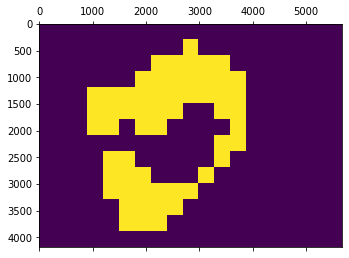

In [ ]:
plt.matshow(first)
plt.show()

In [ ]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level_4, 
                         width=slide.level_dimensions[level_4][0], 
                         height=slide.level_dimensions[level_4][1])

# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level_4, 
                        width=slide.level_dimensions[level_4][0], 
                        height=slide.level_dimensions[level_4][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

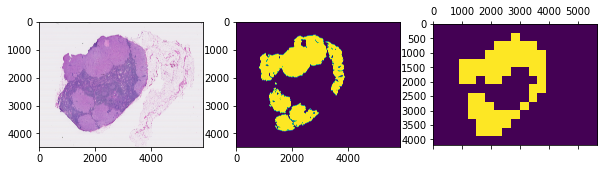

In [ ]:
# fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 1

f, axarr = plt.subplots(1,3, figsize = (10,10)) 
axarr[0].imshow(slide_image)
axarr[1].imshow(mask_image)
axarr[2].matshow(first)